In [4]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import osmnx as ox
from shapely import wkt
import numpy as np
import libpysal as ps

# london boundary from osm
london = ox.geocode_to_gdf('Greater London, UK')
london.to_crs(epsg=27700, inplace=True)

### 1. Load isochrone polygon files as base

In [149]:
pt_isochrone = pd.read_csv(os.path.join('data','cleaned','new_isochrone_15m.csv'),low_memory=False)
# change geometry column to geodataframe with wkt
pt_isochrone['geometry'] = pt_isochrone['geometry'].apply(wkt.loads)
pt_isochrone = gpd.GeoDataFrame(pt_isochrone, geometry='geometry', crs='EPSG:27700')
pt_isochrone.info()

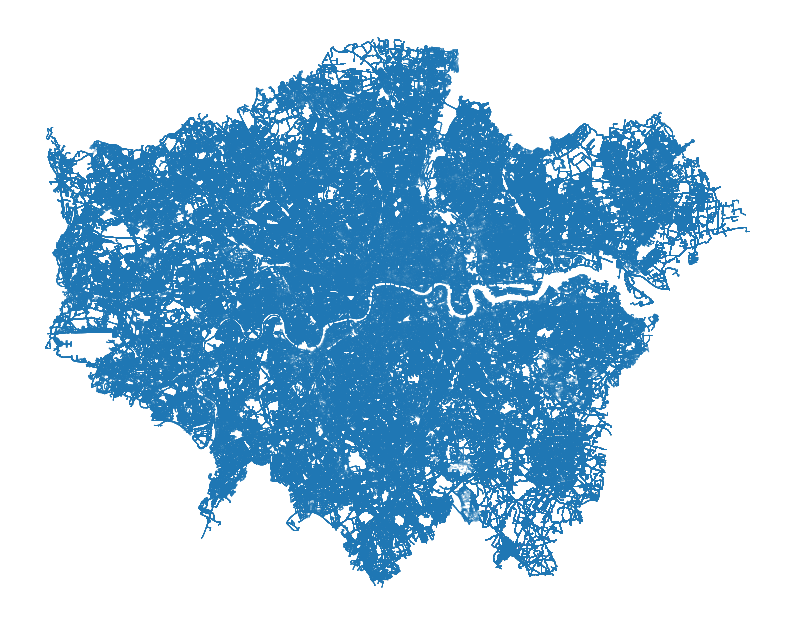

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
pt_isochrone.plot(ax=ax,alpha=0.5)
plt.axis('off')
plt.show()

In [ ]:
# pick a random row in the geodataframe pt_isochrone and plot it 21 32 39 51
random_row = pt_isochrone.sample(2,random_state=1000)
random_row.explore()

### 2. Prep TARGET VARIABLE

In [2]:
timebands = ['Total', 'Morning', 'Midday', 'Evening', 'Late']

In [7]:
# Load processed BUSTO and NUMBAT data
flow_bus = gpd.read_file(os.path.join('data','cleaned','flow_bus_byStop_.gpkg'))
flow_rail = gpd.read_file(os.path.join('data','cleaned','flow_rail.gpkg'))

In [10]:
# sum columns of flow_rail that intersects with each isochrone
for i, row in pt_isochrone.iterrows():
    intersect = flow_rail[flow_rail.geometry.intersects(row.geometry)] # find intersected polygons
    for col in flow_rail[timebands].columns:
        value = intersect[col].sum()
        pt_isochrone.at[i, col] = round(value)
    # print progress
    if i%100==0:
        print(f'{i} of {len(pt_isochrone)} done')

# rename new columns adding a suffix _rail
for col in timebands:
    pt_isochrone.rename(columns={col: col+'_rail'}, inplace=True)

0 of 16890 done
100 of 16890 done
200 of 16890 done
300 of 16890 done
400 of 16890 done
500 of 16890 done
600 of 16890 done
700 of 16890 done
800 of 16890 done
900 of 16890 done
1000 of 16890 done
1100 of 16890 done
1200 of 16890 done
1300 of 16890 done
1400 of 16890 done
1500 of 16890 done
1600 of 16890 done
1700 of 16890 done
1800 of 16890 done
1900 of 16890 done
2000 of 16890 done
2100 of 16890 done
2200 of 16890 done
2300 of 16890 done
2400 of 16890 done
2500 of 16890 done
2600 of 16890 done
2700 of 16890 done
2800 of 16890 done
2900 of 16890 done
3000 of 16890 done
3100 of 16890 done
3200 of 16890 done
3300 of 16890 done
3400 of 16890 done
3500 of 16890 done
3600 of 16890 done
3700 of 16890 done
3800 of 16890 done
3900 of 16890 done
4000 of 16890 done
4100 of 16890 done
4200 of 16890 done
4300 of 16890 done
4400 of 16890 done
4500 of 16890 done
4600 of 16890 done
4700 of 16890 done
4800 of 16890 done
4900 of 16890 done
5000 of 16890 done
5100 of 16890 done
5200 of 16890 done
5300 

In [11]:
# sum total_exits of flow_bus that intersects with each isochrone
for i, row in pt_isochrone.iterrows():
    intersect = flow_bus[flow_bus.geometry.intersects(row.geometry)] # find intersected polygons
    for col in flow_bus[timebands].columns:
        value = intersect[col].sum()
        pt_isochrone.at[i, col] = round(value)
    # print progress
    if i%100==0:
        print(f'{i} of {len(pt_isochrone)} done')

# rename new columns adding a suffix _bus
for col in timebands:
    pt_isochrone.rename(columns={col: col+'_bus'}, inplace=True)

0 of 16890 done
100 of 16890 done
200 of 16890 done
300 of 16890 done
400 of 16890 done
500 of 16890 done
600 of 16890 done
700 of 16890 done
800 of 16890 done
900 of 16890 done
1000 of 16890 done
1100 of 16890 done
1200 of 16890 done
1300 of 16890 done
1400 of 16890 done
1500 of 16890 done
1600 of 16890 done
1700 of 16890 done
1800 of 16890 done
1900 of 16890 done
2000 of 16890 done
2100 of 16890 done
2200 of 16890 done
2300 of 16890 done
2400 of 16890 done
2500 of 16890 done
2600 of 16890 done
2700 of 16890 done
2800 of 16890 done
2900 of 16890 done
3000 of 16890 done
3100 of 16890 done
3200 of 16890 done
3300 of 16890 done
3400 of 16890 done
3500 of 16890 done
3600 of 16890 done
3700 of 16890 done
3800 of 16890 done
3900 of 16890 done
4000 of 16890 done
4100 of 16890 done
4200 of 16890 done
4300 of 16890 done
4400 of 16890 done
4500 of 16890 done
4600 of 16890 done
4700 of 16890 done
4800 of 16890 done
4900 of 16890 done
5000 of 16890 done
5100 of 16890 done
5200 of 16890 done
5300 

In [12]:
# Create a new column with the total number of exits for each timeband
for col in timebands:
    pt_isochrone[col] = pt_isochrone[col+'_rail'] + pt_isochrone[col+'_bus']

# remove columns with _rail and _bus suffix, keep only the combined columns
pt_isochrone.drop(columns=[col+'_rail' for col in timebands]+[col+'_bus' for col in timebands], inplace=True)

In [5]:
# # import df_ml_new
# pt_isochrone = pd.read_csv(os.path.join('data','cleaned','df_ml_new.csv'),low_memory=False)
# # change geometry column to geodataframe with wkt
# pt_isochrone['geometry'] = pt_isochrone['geometry'].apply(wkt.loads)
# pt_isochrone = gpd.GeoDataFrame(pt_isochrone, geometry='geometry', crs='EPSG:27700')
# pt_isochrone.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 16890 entries, 0 to 16889
Data columns (total 39 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   id_code                    16890 non-null  object  
 1   geometry                   16890 non-null  geometry
 2   population                 16890 non-null  float64 
 3   poi_banking                16890 non-null  float64 
 4   poi_hotels                 16890 non-null  float64 
 5   poi_leisure_active         16890 non-null  float64 
 6   poi_leisure_entertainment  16890 non-null  float64 
 7   poi_leisure_outdoor        16890 non-null  float64 
 8   poi_medical                16890 non-null  float64 
 9   poi_nature                 16890 non-null  float64 
 10  poi_public_facilities      16890 non-null  float64 
 11  poi_religious              16890 non-null  float64 
 12  poi_restaurants            16890 non-null  float64 
 13  poi_shopping           

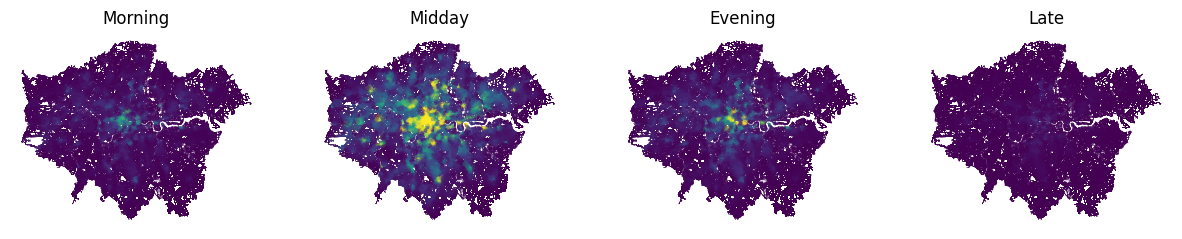

In [7]:
#### plot them
vmin = pt_isochrone['Evening'].min()
vmax = (pt_isochrone['Evening'].max() + pt_isochrone['Late'].max()) /2

# plot 4 timebands
fig, ax = plt.subplots(1,4,figsize=(15,15))
ax = ax.ravel()
for i,time in enumerate(timebands[1:]):
    pt_isochrone.plot(ax=ax[i], column=time, alpha=0.5, cmap='viridis',vmin=vmin,vmax=vmax)
    ax[i].axis('off')
    ax[i].set_title(f'{time}')
plt.savefig(os.path.join('output','pt_arrival_timeband.png'))
plt.show()

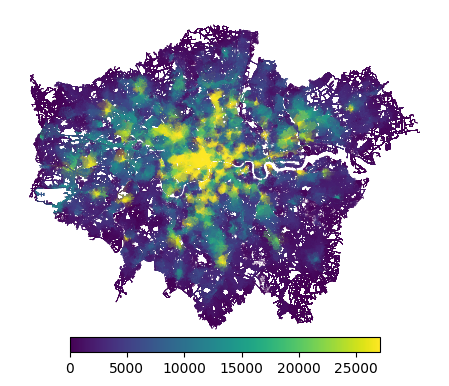

In [6]:
#### plot them
vmin = pt_isochrone['Evening'].min()
vmax = (pt_isochrone['Evening'].max() + pt_isochrone['Late'].max()) /2

# plot total
fig, ax = plt.subplots(1,1,figsize=(10,5))
pt_isochrone.plot(ax=ax, column='Total', alpha=0.5, cmap='viridis',vmin=vmin,vmax=vmax, legend=True, 
                  legend_kwds={
                      'orientation': "horizontal",
                        'shrink': 0.4,
                        'pad': -0.02
                      })
ax.axis('off')
# plt.title('Total arrivals by PT\n(Saturday)')
plt.savefig(os.path.join('output','pt_arrival_total.png'))
plt.show()

### 3. Prep FEATURES
#### 3.1 Aggregate intersecting Population and POI density

In [18]:
# import poi_pop_h3 file
poi_pop_h3 = gpd.read_file(os.path.join('data','cleaned','poi_pop_h3_r10.gpkg'))
poi_pop_h3.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 116586 entries, 0 to 116585
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   h3                         116586 non-null  object  
 1   population                 116586 non-null  int64   
 2   poi_banking                116586 non-null  float64 
 3   poi_hotels                 116586 non-null  float64 
 4   poi_leisure_active         116586 non-null  float64 
 5   poi_leisure_entertainment  116586 non-null  float64 
 6   poi_leisure_outdoor        116586 non-null  float64 
 7   poi_medical                116586 non-null  float64 
 8   poi_nature                 116586 non-null  float64 
 9   poi_public_facilities      116586 non-null  float64 
 10  poi_religious              116586 non-null  float64 
 11  poi_restaurants            116586 non-null  float64 
 12  poi_shopping               116586 non-null  float64 
 13  poi_to

In [19]:
%%time
# takes 6hrs
df_ml = pt_isochrone.copy()

# for each isochrone, calculate the the values from poi_pop_h3 intersecting it 
for i, row in df_ml.iterrows():
    intersect = poi_pop_h3[poi_pop_h3.geometry.intersects(row.geometry)] # find intersected polygons
    #for all columns except geometry 
    for col in intersect.columns[1:-1]: 
        value = intersect[col].sum()
        df_ml.at[i, col] = round(value)
    
    # print progress
    if i%100==0:
        print(f'{i} of {len(df_ml)} done')

df_ml.head()

0 of 16890 done
100 of 16890 done
200 of 16890 done
300 of 16890 done
400 of 16890 done
500 of 16890 done
600 of 16890 done
700 of 16890 done
800 of 16890 done
900 of 16890 done
1000 of 16890 done
1100 of 16890 done
1200 of 16890 done
1300 of 16890 done
1400 of 16890 done
1500 of 16890 done
1600 of 16890 done
1700 of 16890 done
1800 of 16890 done
1900 of 16890 done
2000 of 16890 done
2100 of 16890 done
2200 of 16890 done
2300 of 16890 done
2400 of 16890 done
2500 of 16890 done
2600 of 16890 done
2700 of 16890 done
2800 of 16890 done
2900 of 16890 done
3000 of 16890 done
3100 of 16890 done
3200 of 16890 done
3300 of 16890 done
3400 of 16890 done
3500 of 16890 done
3600 of 16890 done
3700 of 16890 done
3800 of 16890 done
3900 of 16890 done
4000 of 16890 done
4100 of 16890 done
4200 of 16890 done
4300 of 16890 done
4400 of 16890 done
4500 of 16890 done
4600 of 16890 done
4700 of 16890 done
4800 of 16890 done
4900 of 16890 done
5000 of 16890 done
5100 of 16890 done
5200 of 16890 done
5300 

id_code                                           geometry  \
0  89195da4247ffff  POLYGON ((521570.859 187546.641, 521569.897 18...   
1  89194ad9e43ffff  POLYGON ((513302.254 170889.468, 513300.553 17...   
2  89194ad342bffff  POLYGON ((533735.883 181866.208, 533733.441 18...   
3  89194adb167ffff  POLYGON ((518456.922 176045.031, 518456.897 17...   
4  89195da54c7ffff  POLYGON ((519451.094 192052.934, 519450.664 19...   

   Total_rail  Early_rail  AM Peak_rail  Midday_rail  PM Peak_rail  \
0         0.0         0.0           0.0          0.0           0.0   
1         0.0         0.0           0.0          0.0           0.0   
2         0.0         0.0           0.0          0.0           0.0   
3      6496.0        12.0         308.0       3840.0        1274.0   
4         0.0         0.0           0.0          0.0           0.0   

   Evening_rail  Late_rail  Total_bus  ...  poi_medical  poi_nature  \
0           0.0        0.0        0.0  ...          5.0        37.0   
1           0.0        0.0        0.0  ...          7.0        53.0   
2           0.0        0.0        0.0  ...          9.0         2.0   
3         687.0      375.0        0.0  ...         14.0        28.0   
4           0.0        0.0       17.0  ...          4.0        50.0   

   poi_public_facilities  poi_religious  poi_restaurants  poi_shopping  \
0                   31.0            4.0             26.0          47.0   
1                   56.0            4.0             34.0          51.0   
2                   70.0            7.0            189.0         207.0   
3                   65.0            5.0             48.0          67.0   
4                   39.0            7.0             17.0          26.0   

   poi_tourism  transport_bus  transport_other  transport_rail  
0          7.0           51.0             31.0             2.0  
1          3.0           36.0              0.0             1.0  
2         35.0           19.0              0.0             2.0  
3         63.0           31.0              0.0             1.0  
4          0.0           44.0             32.0             1.0  

[5 rows x 39 columns]

#### 3.2 Calculate POI diversity - Shannon entropy within each isochrone

In [20]:
df_ml_div = df_ml.copy()

In [8]:
# Load borough shapefile for Islington borough using osmnx
boros = gpd.read_file(os.path.join('data','shapefile','statistical-gis-boundaries-london','ESRI','London_Borough_Excluding_MHW.shp'))
boros.to_crs(epsg=27700, inplace=True)

In [22]:
# calculate the entropy of all rows
from scipy.stats import entropy
def calc_poi_entropy(row):

    # get the values of the row only for columns whose name contain poi_
    c = row.filter(like='poi_').values.astype(int)
    # remove zeros
    c = c[c != 0]
    c = c / c.sum()
    # calculate the entropy
    ent = entropy(c)
    return ent

df_ml_div['diversity_poi'] = df_ml_div.apply(calc_poi_entropy, axis=1)

<Axes: title={'center': 'Top 10% POI diversity'}>

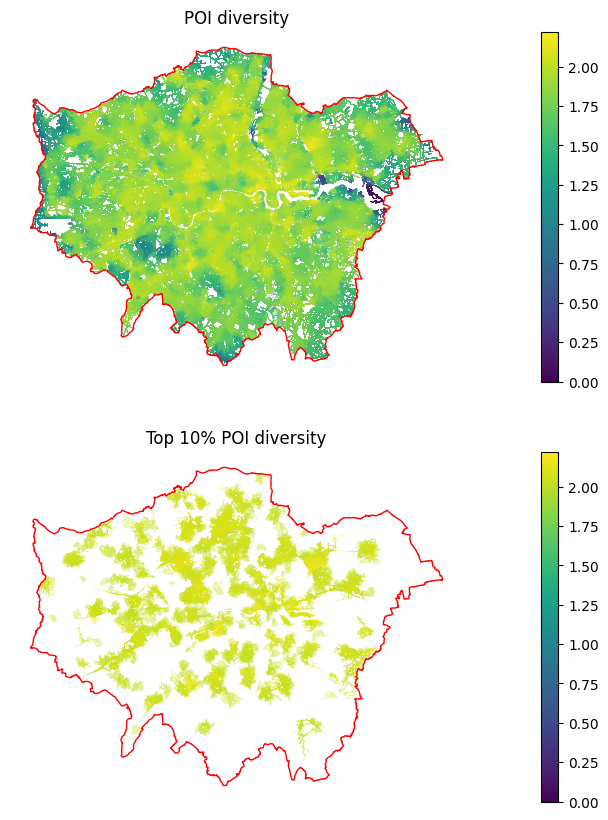

In [23]:
# plot it where entropy is greater than top quartile, same color scale
fig, ax = plt.subplots(2,1,figsize=(20,10))

vmin = df_ml_div.diversity_poi.min()
vmax = df_ml_div.diversity_poi.max()

df_ml_div.plot(column='diversity_poi', 
           ax=ax[0],
           legend=True, 
           alpha=0.5, 
           cmap='viridis',vmin=vmin,vmax=vmax
           ).set_title('POI diversity')
ax[0].axis('off')

df_ml_div[df_ml_div.diversity_poi > df_ml_div.diversity_poi.quantile(0.90)].plot(
            column='diversity_poi', 
            ax=ax[1],
            legend=True,
            alpha=0.5,
            cmap='viridis',vmin=vmin,vmax=vmax
            ).set_title('Top 10% POI diversity')
ax[1].axis('off')

london.boundary.plot(ax=ax[0], color='red', linewidth=1)
london.boundary.plot(ax=ax[1], color='red', linewidth=1)

#### 3.3 Calculate Transport mode diversity Bus/Rail/Other - Shannon entropy within each isochrone

In [24]:
# calculate the entropy of all rows
from scipy.stats import entropy
def calc_transport_entropy(row):
    # get the values of the row only for columns whose name contain poi_
    c = row.filter(like='transport_').values.astype(int)
    # remove zeros
    c = c[c != 0]
    c = c / c.sum()
    # calculate the entropy
    ent = entropy(c)
    return ent

df_ml_div['diversity_transp_mode'] = df_ml_div.apply(calc_transport_entropy, axis=1)

<Axes: title={'center': 'Top 10% Transport mode diversity'}>

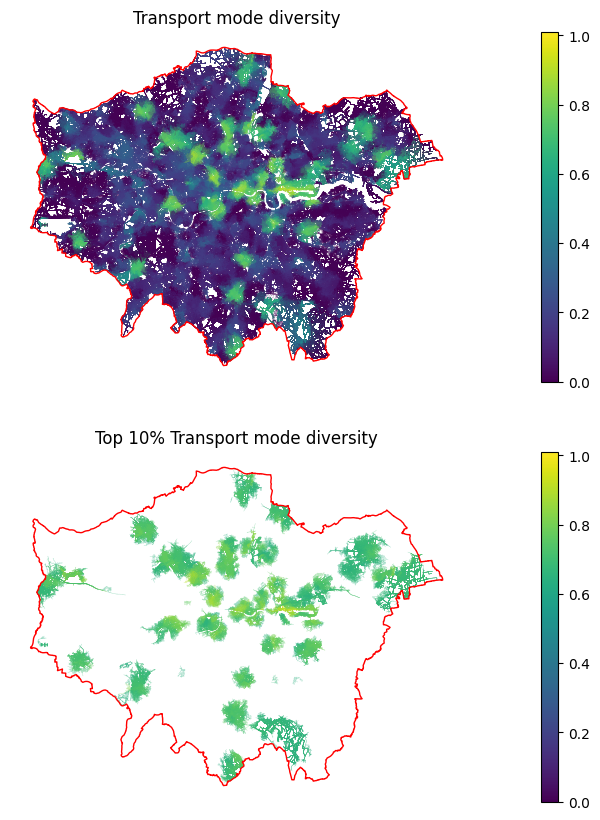

In [25]:
# plot it where entropy is greater than top quartile, same color scale
fig, ax = plt.subplots(2,1,figsize=(20,10))

vmin = df_ml_div.diversity_transp_mode.min()
vmax = df_ml_div.diversity_transp_mode.max()

df_ml_div.plot(column='diversity_transp_mode', 
           ax=ax[0],
           legend=True, 
           alpha=0.5, 
           cmap='viridis',vmin=vmin,vmax=vmax
           ).set_title('Transport mode diversity')
ax[0].axis('off')

df_ml_div[df_ml_div.diversity_transp_mode > df_ml_div.diversity_transp_mode.quantile(0.90)].plot(
            column='diversity_transp_mode', 
            ax=ax[1],
            legend=True,
            alpha=0.5,
            cmap='viridis',vmin=vmin,vmax=vmax
            ).set_title('Top 10% Transport mode diversity')
ax[1].axis('off')

london.boundary.plot(ax=ax[0], color='red', linewidth=1)
london.boundary.plot(ax=ax[1], color='red', linewidth=1)

#### 3.4 Transport operator mode

In [13]:
import requests
import json
import numpy as np

df_ml_div = pt_isochrone.copy() # delete when done
df_ml_div.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 16890 entries, 0 to 16889
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   id_code                    16890 non-null  object  
 1   geometry                   16890 non-null  geometry
 2   population                 16890 non-null  float64 
 3   poi_banking                16890 non-null  float64 
 4   poi_hotels                 16890 non-null  float64 
 5   poi_leisure_active         16890 non-null  float64 
 6   poi_leisure_entertainment  16890 non-null  float64 
 7   poi_leisure_outdoor        16890 non-null  float64 
 8   poi_medical                16890 non-null  float64 
 9   poi_nature                 16890 non-null  float64 
 10  poi_public_facilities      16890 non-null  float64 
 11  poi_religious              16890 non-null  float64 
 12  poi_restaurants            16890 non-null  float64 
 13  poi_shopping           

Rail

In [14]:
# function to get lat long from postcode

def get_lat_long(postcode):
    url = f'https://api.postcodes.io/postcodes/{postcode}'
    response = requests.get(url)
    if response.status_code == 200:
        data = json.loads(response.text)
        return data['result']['latitude'], data['result']['longitude']
    else:
        return np.nan, np.nan

In [15]:
# Load Railway station (by opt) location data
df = pd.read_csv(os.path.join('data','raw','tfl','Station - 2011-12.csv'))
df = df[df['County or Unitary Authority'] == 'Greater London'] # Filter for London
# create new column for postcode, trim last 3 characters of the location for map
df['Postcode'] = df['Location for map'].str[:-4]
# remove London Underground and London Overground stations in Station Facility Owner
df = df[~df['Station Facility Owner'].str.contains('London Underground')]
df = df[~df['Station Facility Owner'].str.contains('London Overground')]
df.head()

NLC Origin TLC     Station Name Location for map  \
0   7492        BKG          Barking     IG11 8TU, UK   
19  7440        DDK    Dagenham Dock      RM9 6PT, UK   
20  7491        LHS        Limehouse      E14 7JD, UK   
33  7454        RNM  Rainham (Essex)     RM13 9HY, UK   
39  7464        UPM        Upminster     RM14 2TD, UK   

   Government Office Region (GOR) County or Unitary Authority  \
0                          London              Greater London   
19                         London              Greater London   
20                         London              Greater London   
33                         London              Greater London   
39                         London              Greater London   

   District or Unitary Authority NUTS2 Spatial_Unit Code NUTS2 Spatial Unit  \
0           Barking And Dagenham                    UKI2       Outer London   
19          Barking And Dagenham                    UKI2       Outer London   
20                 Tower Hamlets                    UKI1       Inner London   
33                      Havering                    UKI2       Outer London   
39                      Havering                    UKI2       Outer London   

   Station Facility Owner          London Travelcard Area  Postcode  
0                     c2c  London Travelcard Area Station  IG11 8TU  
19                    c2c  London Travelcard Area Station   RM9 6PT  
20                    c2c  London Travelcard Area Station   E14 7JD  
33                    c2c  London Travelcard Area Station  RM13 9HY  
39                    c2c  London Travelcard Area Station  RM14 2TD

In [16]:
# Get lat long for each postcode
df['Latlon'] = df['Postcode'].apply(get_lat_long) 
df.head()   

NLC Origin TLC     Station Name Location for map  \
0   7492        BKG          Barking     IG11 8TU, UK   
19  7440        DDK    Dagenham Dock      RM9 6PT, UK   
20  7491        LHS        Limehouse      E14 7JD, UK   
33  7454        RNM  Rainham (Essex)     RM13 9HY, UK   
39  7464        UPM        Upminster     RM14 2TD, UK   

   Government Office Region (GOR) County or Unitary Authority  \
0                          London              Greater London   
19                         London              Greater London   
20                         London              Greater London   
33                         London              Greater London   
39                         London              Greater London   

   District or Unitary Authority NUTS2 Spatial_Unit Code NUTS2 Spatial Unit  \
0           Barking And Dagenham                    UKI2       Outer London   
19          Barking And Dagenham                    UKI2       Outer London   
20                 Tower Hamlets                    UKI1       Inner London   
33                      Havering                    UKI2       Outer London   
39                      Havering                    UKI2       Outer London   

   Station Facility Owner          London Travelcard Area  Postcode  \
0                     c2c  London Travelcard Area Station  IG11 8TU   
19                    c2c  London Travelcard Area Station   RM9 6PT   
20                    c2c  London Travelcard Area Station   E14 7JD   
33                    c2c  London Travelcard Area Station  RM13 9HY   
39                    c2c  London Travelcard Area Station  RM14 2TD   

                    Latlon  
0    (51.539322, 0.080979)  
19              (nan, nan)  
20  (51.512605, -0.040203)  
33    (51.512476, 0.20085)  
39   (51.558504, 0.250535)

In [17]:
# geo dataframe
df[['Latitude','Longitude']] = pd.DataFrame(df['Latlon'].tolist(), index=df.index)
rail_opt = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs='EPSG:4326')
rail_opt = rail_opt.to_crs('EPSG:27700')
rail_opt = rail_opt[['NLC','Station Name','Station Facility Owner','geometry']]

# rename columns
rail_opt.columns = ['nlc','name','operator','geometry']
rail_opt.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 269 entries, 0 to 2499
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   nlc       269 non-null    int64   
 1   name      269 non-null    object  
 2   operator  269 non-null    object  
 3   geometry  269 non-null    geometry
dtypes: geometry(1), int64(1), object(2)
memory usage: 10.5+ KB


In [18]:
# TFL stations
df1 = pd.read_csv(os.path.join('data','raw','tfl','numbat_geometry.csv'))
# GEO data frame
df1['geometry'] = gpd.GeoSeries.from_wkt(df1['geometry'])
rail_opt_tfl = gpd.GeoDataFrame(df1, crs='EPSG:4326')
rail_opt_tfl = rail_opt_tfl.to_crs('EPSG:27700')
rail_opt_tfl['operator'] = 'TfL'
rail_opt_tfl = rail_opt_tfl.drop(columns=['asc'])
# rename columns
rail_opt_tfl.columns = ['nlc','name','geometry','operator']
rail_opt_tfl.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 432 entries, 0 to 431
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   nlc       432 non-null    int64   
 1   name      432 non-null    object  
 2   geometry  432 non-null    geometry
 3   operator  432 non-null    object  
dtypes: geometry(1), int64(1), object(2)
memory usage: 13.6+ KB


In [19]:
# concat tfl and other rail opt stations
rail_stn_op = pd.concat([rail_opt,rail_opt_tfl],ignore_index=True)
rail_stn_op = rail_stn_op[rail_stn_op['geometry'].is_empty == False]
rail_stn_op.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 668 entries, 0 to 700
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   nlc       668 non-null    int64   
 1   name      668 non-null    object  
 2   operator  668 non-null    object  
 3   geometry  668 non-null    geometry
dtypes: geometry(1), int64(1), object(2)
memory usage: 26.1+ KB


In [20]:
# loop through each isochrone
for i, isochrone in pt_isochrone.iterrows():
    # create a list to store the route_ids
    route_ids1 = []
    # get the stops that are within the isochrone
    stops_within = rail_stn_op[rail_stn_op.geometry.within(isochrone.geometry)]
    # get the route_ids for those stops
    route_ids1.extend(stops_within['operator'].unique())
    route_ids1 = list(set(route_ids1))
    # create new column in the original df to store the route_ids
    pt_isochrone.loc[i,'route_ids1'] = str(route_ids1)
    # print the progress
    if i % 100 == 0:
        print(f'{i} of {len(pt_isochrone)} processed')

0 of 16890 processed
100 of 16890 processed
200 of 16890 processed
300 of 16890 processed
400 of 16890 processed
500 of 16890 processed
600 of 16890 processed
700 of 16890 processed
800 of 16890 processed
900 of 16890 processed
1000 of 16890 processed
1100 of 16890 processed
1200 of 16890 processed
1300 of 16890 processed
1400 of 16890 processed
1500 of 16890 processed
1600 of 16890 processed
1700 of 16890 processed
1800 of 16890 processed
1900 of 16890 processed
2000 of 16890 processed
2100 of 16890 processed
2200 of 16890 processed
2300 of 16890 processed
2400 of 16890 processed
2500 of 16890 processed
2600 of 16890 processed
2700 of 16890 processed
2800 of 16890 processed
2900 of 16890 processed
3000 of 16890 processed
3100 of 16890 processed
3200 of 16890 processed
3300 of 16890 processed
3400 of 16890 processed
3500 of 16890 processed
3600 of 16890 processed
3700 of 16890 processed
3800 of 16890 processed
3900 of 16890 processed
4000 of 16890 processed
4100 of 16890 processed
4200

Bus route

In [21]:
# bus routes
bus_route = gpd.read_file(os.path.join('data','cleaned','flow_bus_byStopRoutes_.gpkg'))
bus_route.to_crs('EPSG:27700',inplace=True)
bus_route.head()

STOPCODE                              STOPNAME ROUTE  Morning    Midday  \
0     1000  WESTMINSTER STN  / PARLIAMENT SQUARE    12  3.16854  20.90640   
1     1000  WESTMINSTER STN  / PARLIAMENT SQUARE   159  1.79745  25.62950   
2     1000  WESTMINSTER STN  / PARLIAMENT SQUARE   453  8.20901  95.92944   
3     1000  WESTMINSTER STN  / PARLIAMENT SQUARE  N109      NaN       NaN   
4     1000  WESTMINSTER STN  / PARLIAMENT SQUARE  N155  0.00141       NaN   

      Late   Evening      Total                       geometry  
0  6.57087  28.61594   59.26175  POINT (530171.000 179738.000)  
1  5.97318  25.33188   58.73201  POINT (530171.000 179738.000)  
2  7.93913  40.49001  152.56759  POINT (530171.000 179738.000)  
3  1.48756       NaN    1.48756  POINT (530171.000 179738.000)  
4  0.86524       NaN    0.86665  POINT (530171.000 179738.000)

In [24]:
%%time
# loop through each isochrone
for i, isochrone in pt_isochrone.iterrows():
    # create a list to store the route_ids
    route_ids = []
    # get the stops that are within the isochrone
    stops_within = bus_route[bus_route.geometry.within(isochrone.geometry)]
    # get the route_ids for those stops
    route_ids.extend(stops_within['ROUTE'].unique())
    route_ids = list(set(route_ids))
    # create new column in the original df to store the route_ids
    pt_isochrone.loc[i,'route_ids'] = str(route_ids)
    # print the progress
    if i % 100 == 0:
        print(f'{i} of {len(pt_isochrone)} processed')

0 of 16890 processed
100 of 16890 processed
200 of 16890 processed
300 of 16890 processed
400 of 16890 processed
500 of 16890 processed
600 of 16890 processed
700 of 16890 processed
800 of 16890 processed
900 of 16890 processed
1000 of 16890 processed
1100 of 16890 processed
1200 of 16890 processed
1300 of 16890 processed
1400 of 16890 processed
1500 of 16890 processed
1600 of 16890 processed
1700 of 16890 processed
1800 of 16890 processed
1900 of 16890 processed
2000 of 16890 processed
2100 of 16890 processed
2200 of 16890 processed
2300 of 16890 processed
2400 of 16890 processed
2500 of 16890 processed
2600 of 16890 processed
2700 of 16890 processed
2800 of 16890 processed
2900 of 16890 processed
3000 of 16890 processed
3100 of 16890 processed
3200 of 16890 processed
3300 of 16890 processed
3400 of 16890 processed
3500 of 16890 processed
3600 of 16890 processed
3700 of 16890 processed
3800 of 16890 processed
3900 of 16890 processed
4000 of 16890 processed
4100 of 16890 processed
4200

Calculate entropy

In [22]:
from scipy.stats import entropy
import numpy as np

In [27]:
# iterate through each row
for i, row in pt_isochrone.iterrows():
    # convert the string back to a list
    c = eval(row['route_ids'])
    d = eval(row['route_ids1'])

    # combine the two lists
    c.extend(d)
    
    # count the frequency of each element, 
    c = np.array([c.count(x) for x in set(c)])

    # then calculate the probability
    c = c[c != 0]
    c = c / c.sum()

    # calculate the entropy
    ent = entropy(c)
    # add to the original df
    pt_isochrone.loc[i,'diversity_transp_opt'] = ent

    # print the progress
    if i % 100 == 0:
        print(f'{i} of {len(pt_isochrone)} processed')

pt_isochrone.head()   

0 of 16890 processed
100 of 16890 processed
200 of 16890 processed
300 of 16890 processed
400 of 16890 processed
500 of 16890 processed
600 of 16890 processed
700 of 16890 processed
800 of 16890 processed
900 of 16890 processed
1000 of 16890 processed
1100 of 16890 processed
1200 of 16890 processed
1300 of 16890 processed
1400 of 16890 processed
1500 of 16890 processed
1600 of 16890 processed
1700 of 16890 processed
1800 of 16890 processed
1900 of 16890 processed
2000 of 16890 processed
2100 of 16890 processed
2200 of 16890 processed
2300 of 16890 processed
2400 of 16890 processed
2500 of 16890 processed
2600 of 16890 processed
2700 of 16890 processed
2800 of 16890 processed
2900 of 16890 processed
3000 of 16890 processed
3100 of 16890 processed
3200 of 16890 processed
3300 of 16890 processed
3400 of 16890 processed
3500 of 16890 processed
3600 of 16890 processed
3700 of 16890 processed
3800 of 16890 processed
3900 of 16890 processed
4000 of 16890 processed
4100 of 16890 processed
4200

id_code                                           geometry  \
0  89195da4247ffff  POLYGON ((521570.859 187546.641, 521569.897 18...   
1  89194ad9e43ffff  POLYGON ((513302.254 170889.468, 513300.553 17...   
2  89194ad342bffff  POLYGON ((533735.883 181866.208, 533733.441 18...   
3  89194adb167ffff  POLYGON ((518456.922 176045.031, 518456.897 17...   
4  89195da54c7ffff  POLYGON ((519451.094 192052.934, 519450.664 19...   

   population  poi_banking  poi_hotels  poi_leisure_active  \
0     14163.0          7.0         4.0                18.0   
1      7618.0          1.0         0.0                77.0   
2     15290.0         14.0         8.0                42.0   
3     10157.0          3.0         5.0                34.0   
4     18357.0          6.0         0.0                 2.0   

   poi_leisure_entertainment  poi_leisure_outdoor  poi_medical  poi_nature  \
0                        0.0                 21.0          5.0        37.0   
1                        1.0                 36.0          7.0        53.0   
2                        7.0                 75.0          9.0         2.0   
3                        0.0                 29.0         14.0        28.0   
4                        0.0                 23.0          4.0        50.0   

   ...  rail_betweenness_t       x_coords       y_coords    Total  Morning  \
0  ...         1584.000000  522513.995081  188148.521708  10197.0   1655.0   
1  ...            0.000000  514018.159857  171288.603904   1954.0    234.0   
2  ...        21610.387049  534165.372284  182394.904152   4418.0    422.0   
3  ...          399.000000  518920.317004  176569.897639   8378.0    501.0   
4  ...            0.000000  520106.493398  192652.695300   2852.0    414.0   

   Midday  Evening   Late                        route_ids1  \
0  6400.0   1803.0  338.0         ['First Capital Connect']   
1  1287.0    370.0   63.0                                []   
2  2858.0    914.0  224.0  ['National Express East Anglia']   
3  6483.0   1281.0  113.0                           ['TfL']   
4  1714.0    644.0   81.0                                []   

                                           route_ids  
0  ['143', 'N113', '324', '182', 'N83', '266', 'N...  
1                              ['285', 'R70', 'R68']  
2                           ['D3', 'N8', '388', '8']  
3                        ['65', 'N65', '110', 'R70']  
4  ['107', '384', '113', '221', '240', 'N113', '2...  

[5 rows x 36 columns]

Merge new column into df_ml_div

In [ ]:
df_ml_div = df_ml_div.merge(pt_isochrone[['id_code','diversity_transp_opt']],on='id_code',how='left')
df_ml_div.info() # should have 1 new column and 16890 row

Plot

<Axes: title={'center': 'Top 10% Transport option diversity'}>

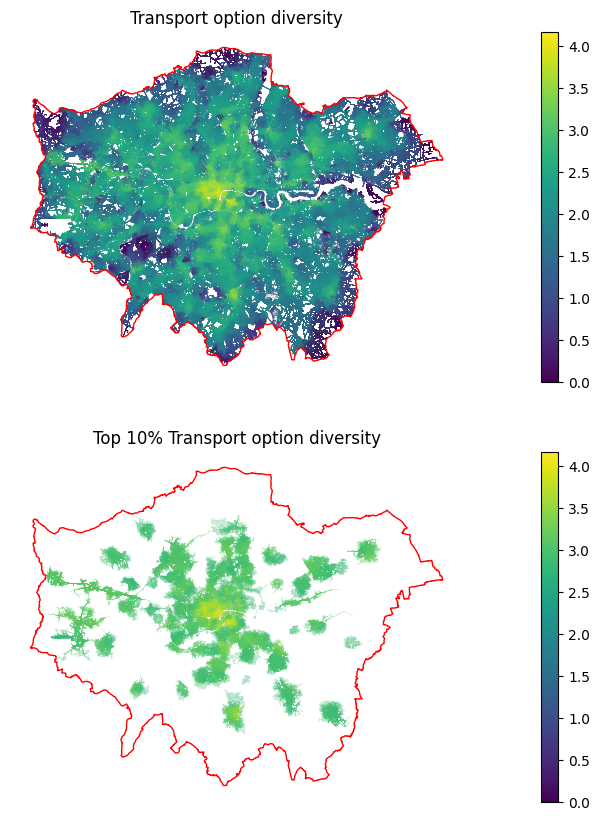

In [41]:
# plot it where entropy is greater than top quartile, same color scale
fig, ax = plt.subplots(2,1,figsize=(20,10))

vmin = df_ml_div.diversity_transp_opt.min()
vmax = df_ml_div.diversity_transp_opt.max()

df_ml_div.plot(column='diversity_transp_opt', 
           ax=ax[0],
           legend=True, 
           alpha=0.5, 
           cmap='viridis',vmin=vmin,vmax=vmax
           ).set_title('Transport option diversity')
ax[0].axis('off')

df_ml_div[df_ml_div.diversity_transp_opt > df_ml_div.diversity_transp_opt.quantile(0.90)].plot(
            column='diversity_transp_opt', 
            ax=ax[1],
            legend=True,
            alpha=0.5,
            cmap='viridis',vmin=vmin,vmax=vmax
            ).set_title('Top 10% Transport option diversity')
ax[1].axis('off')

london.boundary.plot(ax=ax[0], color='red', linewidth=1)
london.boundary.plot(ax=ax[1], color='red', linewidth=1)

#### Plot all div together for each boro

In [ ]:
#normalise the 3 diversity columns, range 0-1
div_col = [col for col in df_ml_div.columns if 'diversity' in col]
for col in div_col:
    df_ml_div[col] = (df_ml_div[col] - df_ml_div[col].min()) / (df_ml_div[col].max() - df_ml_div[col].min())    

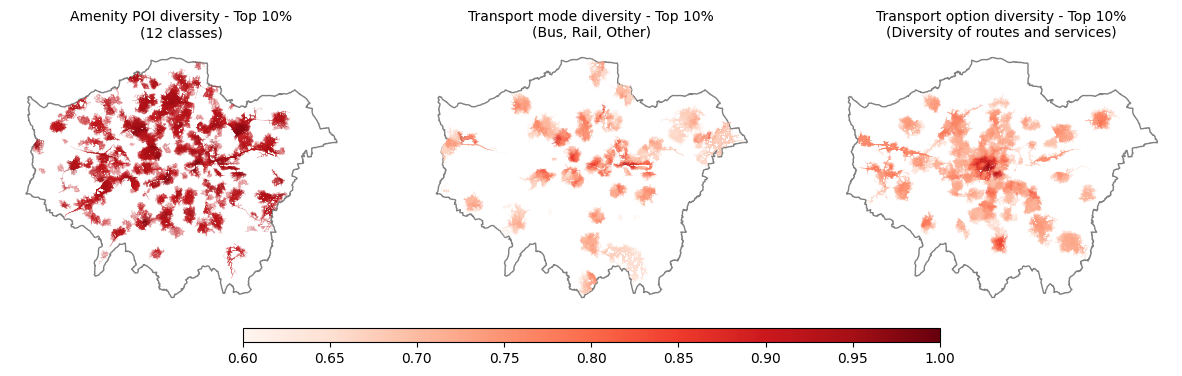

In [6]:
# for each boro in boro geodataframe, plot ALL THREE diversity maps
fig, ax = plt.subplots(1,3,sharex=True, sharey=True,figsize=(15,5))

for i in range(3):
   london.plot(ax=ax[i], color='white', edgecolor='grey')

vmin=0.6
vmax=1

df_plot = df_ml_div[df_ml_div.diversity_poi > df_ml_div.diversity_poi.quantile(0.90)]
df_plot.plot(
    column='diversity_poi',
    ax=ax[0],
    alpha=0.5,
    cmap='Reds', vmin=vmin, vmax=vmax
)
ax[0].axis('off')
ax[0].set_aspect('equal', adjustable='box')
ax[0].set_title(f'Amenity POI diversity - Top 10%\n(12 classes)', fontsize=10)


df_plot = df_ml_div[df_ml_div.diversity_transp_mode > df_ml_div.diversity_transp_mode.quantile(0.90)] 
df_plot.plot(
    column='diversity_transp_mode',
    ax=ax[1],
    alpha=0.5,
    cmap='Reds', vmin=vmin, vmax=vmax

)
ax[1].axis('off')
ax[1].set_aspect('equal', adjustable='box')
ax[1].set_title(f'Transport mode diversity - Top 10%\n(Bus, Rail, Other)', fontsize=10)

df_plot = df_ml_div[df_ml_div.diversity_transp_opt > df_ml_div.diversity_transp_opt.quantile(0.90)]
df_plot.plot(
    column='diversity_transp_opt',
    ax=ax[2],
    alpha=0.5,
    cmap='Reds', vmin=vmin, vmax=vmax
    )
ax[2].axis('off')
ax[2].set_aspect('equal', adjustable='box')
ax[2].set_title(f'Transport option diversity - Top 10%\n(Diversity of routes and services)', fontsize=10)

#add legend
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', pad=0.05, aspect=50,shrink=0.6)

# plt.suptitle('iversity feature\nTop 10% values', fontsize=12, y=0.9)
plt.show()

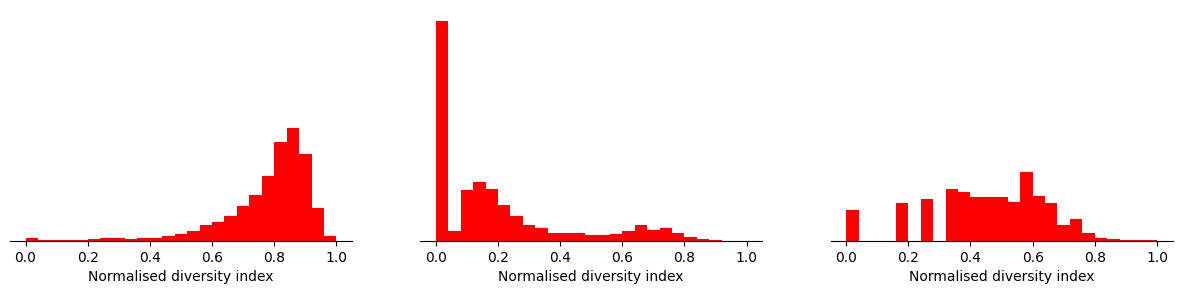

In [58]:
fig, ax = plt.subplots(1,3,sharex=True, sharey=True,figsize=(15,3))



# histogram of diversity_poi
df_ml_div.diversity_poi.hist(bins=25, ax=ax[0], color='red')
# ax[0].set_title('Amenity POI diversity\n(12 classes)', fontsize=10)

# histogram of diversity_transp_mode
df_ml_div.diversity_transp_mode.hist(bins=25, ax=ax[1], color='red')
# ax[1].set_title('Transport mode diversity\n(Bus, Rail, Other)', fontsize=10)


# histogram of diversity_transp_opt
df_ml_div.diversity_transp_opt.hist(bins=25, ax=ax[2], color='red')
# ax[2].set_title('Transport option diversity\n(Diversity of routes and services)', fontsize=10)

for i in range(3):
    ax[i].set_xlabel('Normalised diversity index')
    ax[i].set_ylabel('')
    ax[i].grid(False)
    ax[i].set_yticks([])
    # no frame
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['left'].set_visible(False)

plt.show()

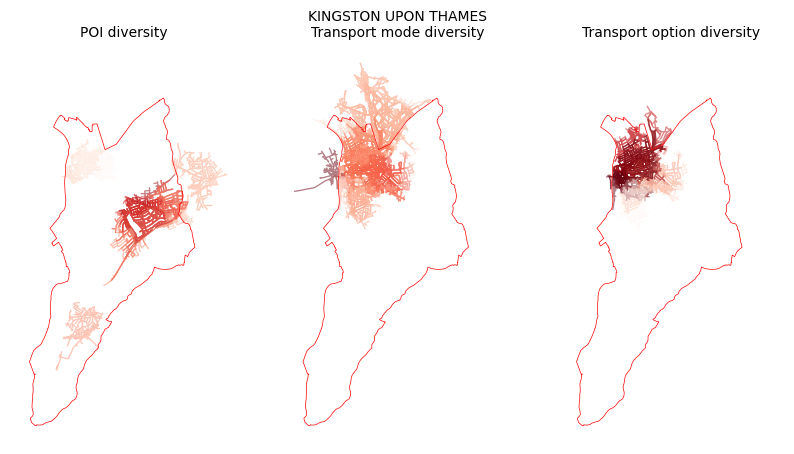

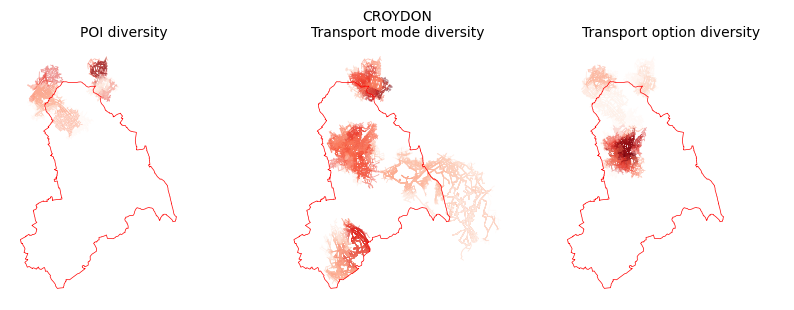

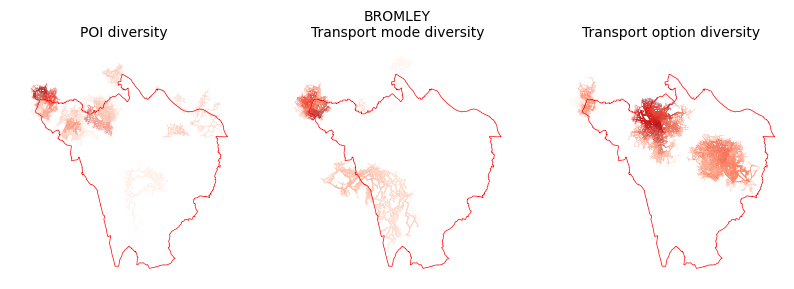

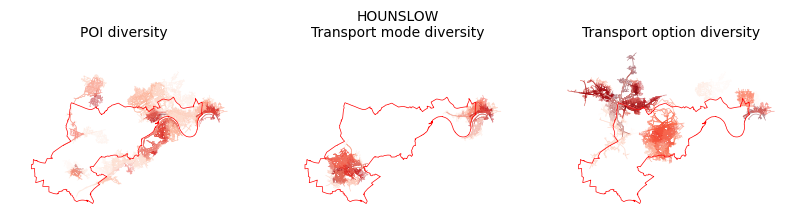

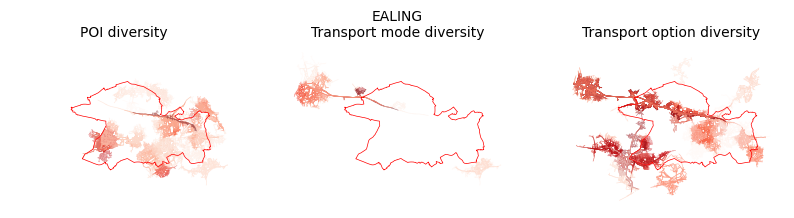

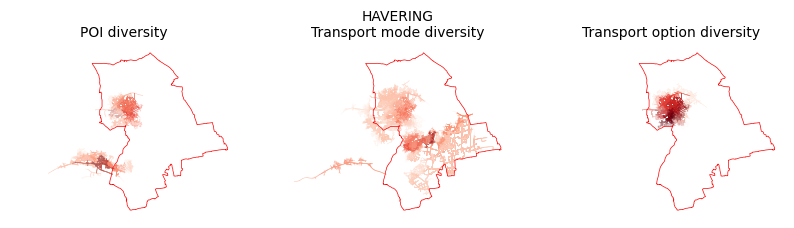

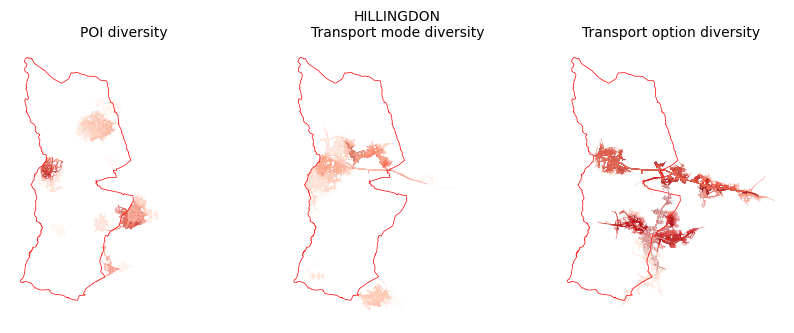

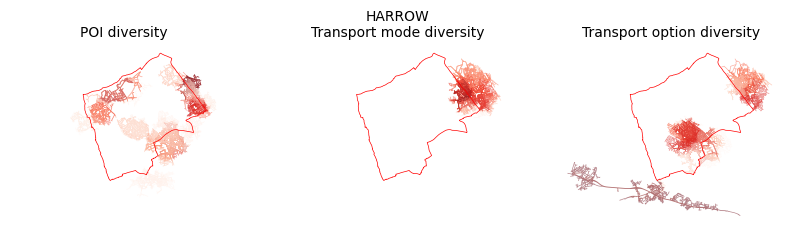

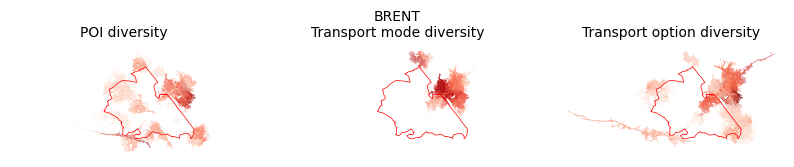

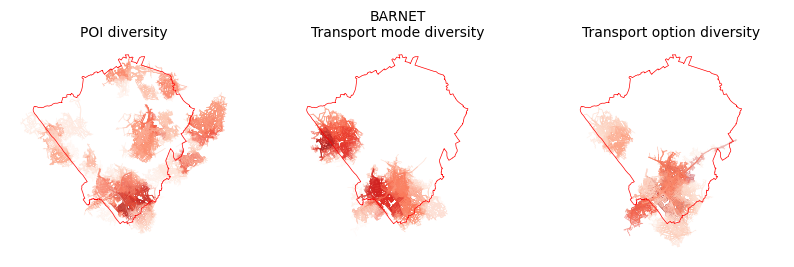

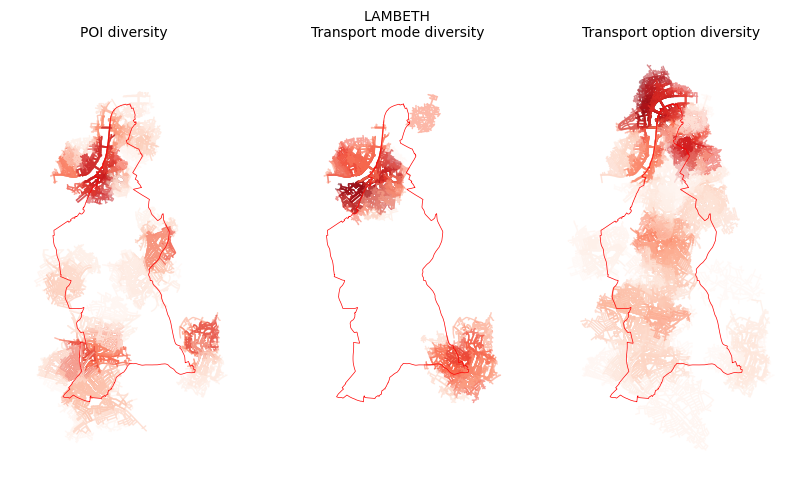

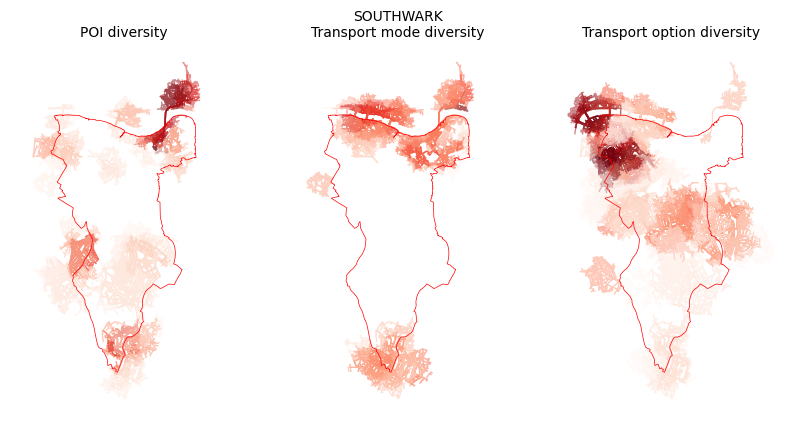

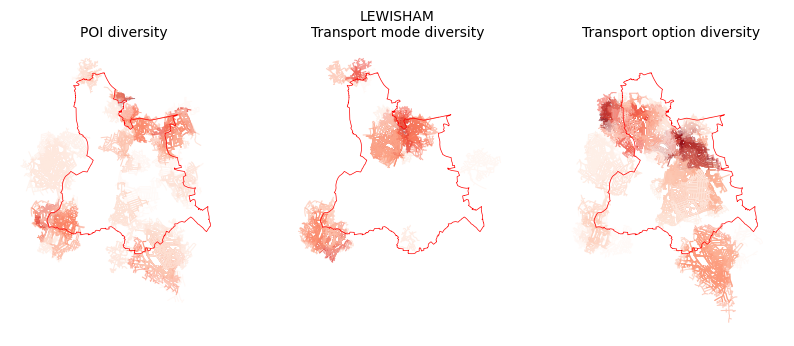

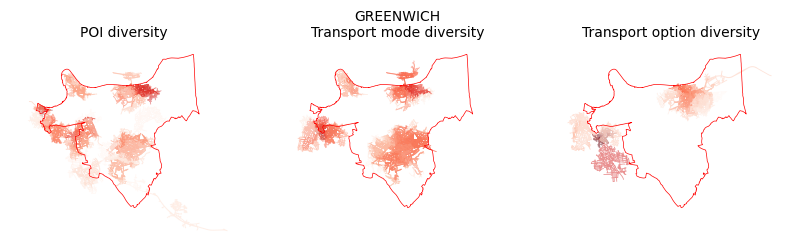

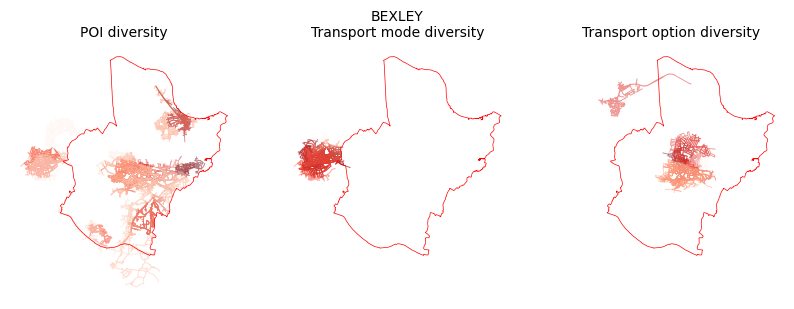

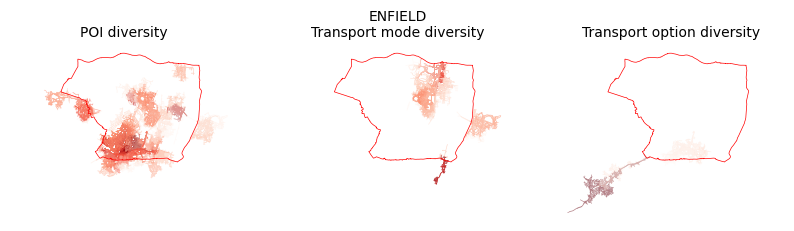

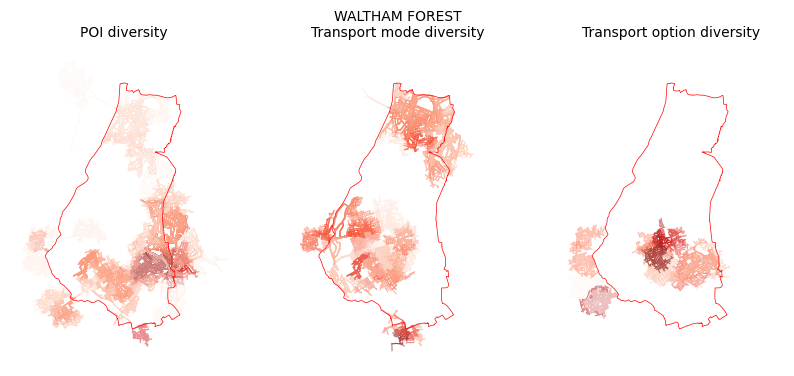

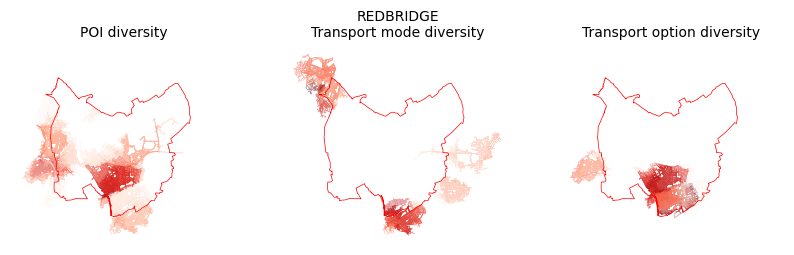

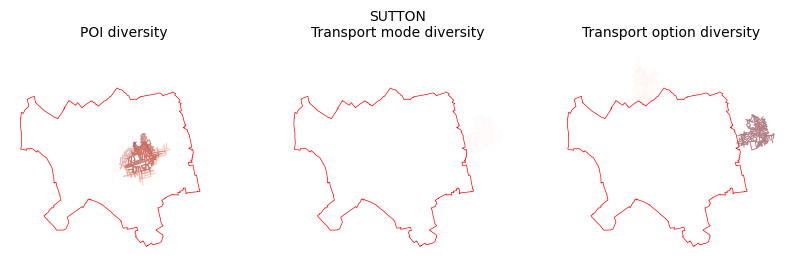

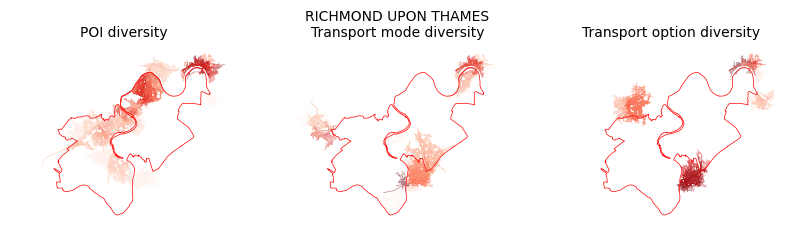

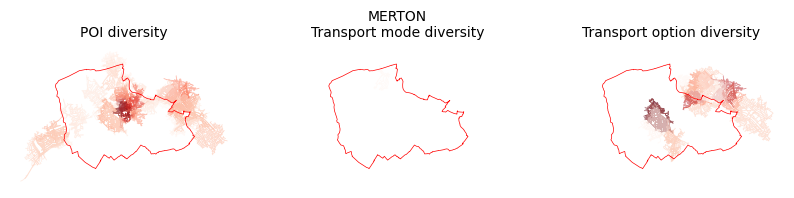

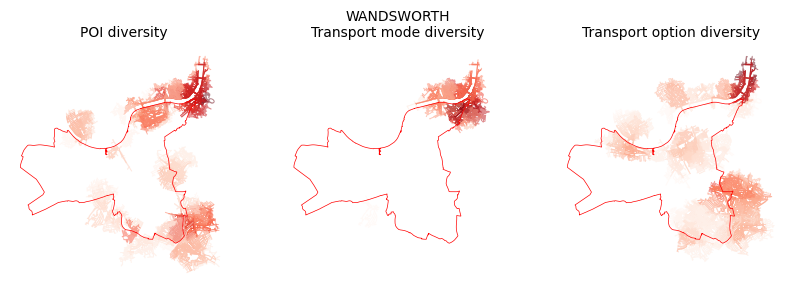

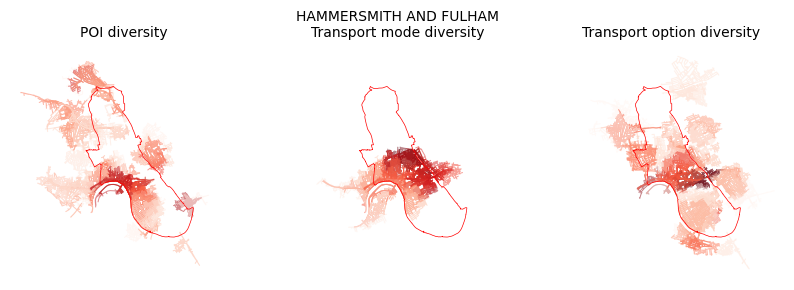

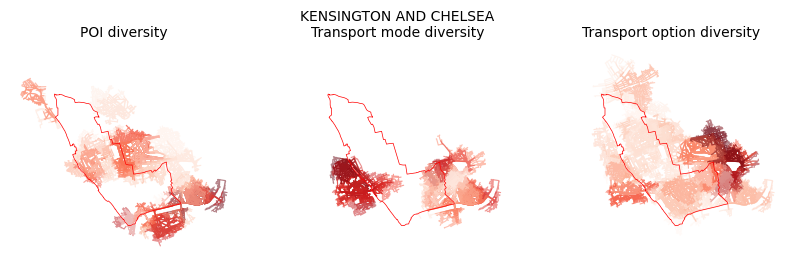

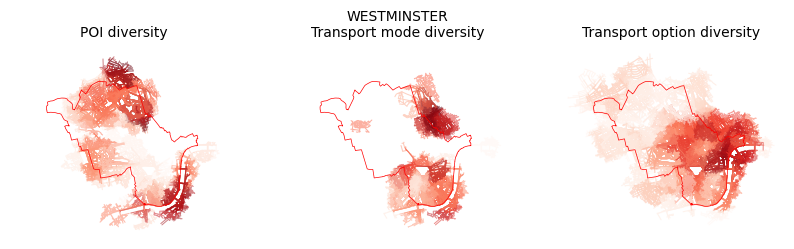

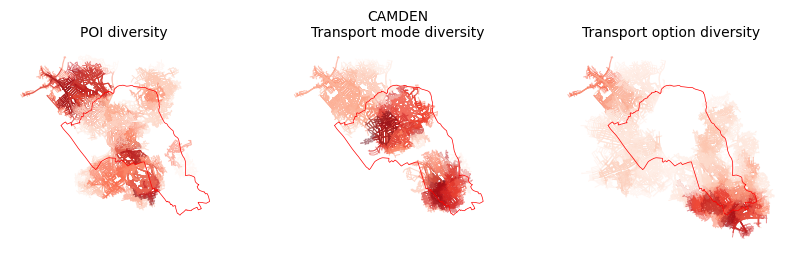

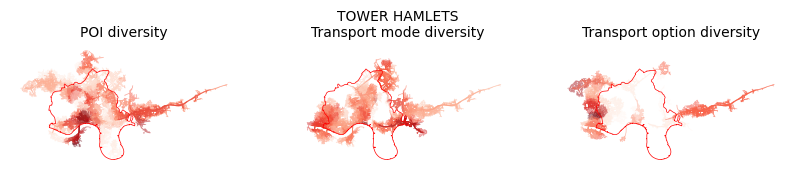

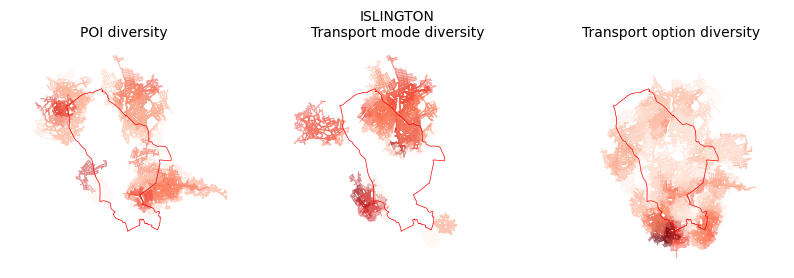

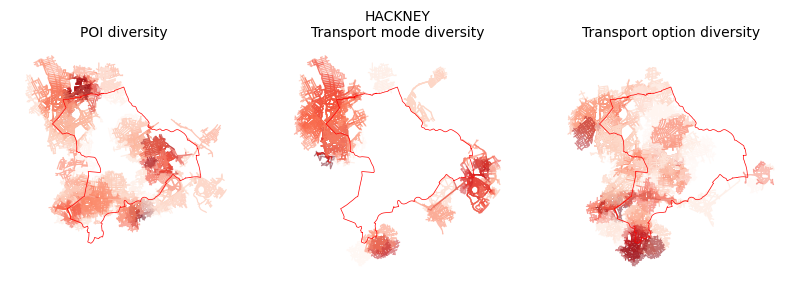

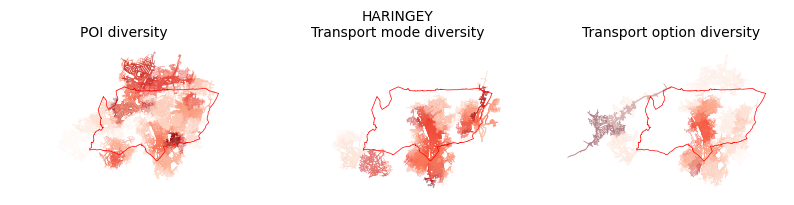

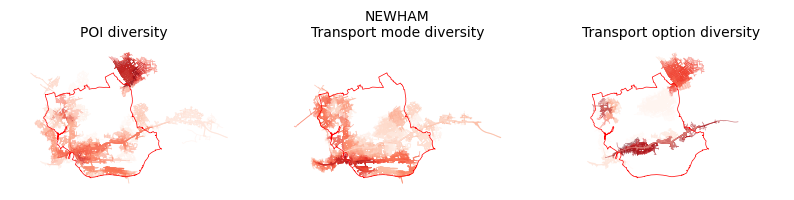

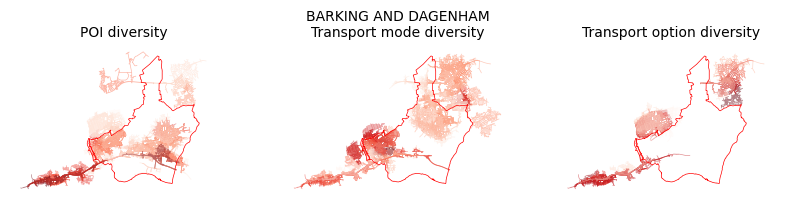

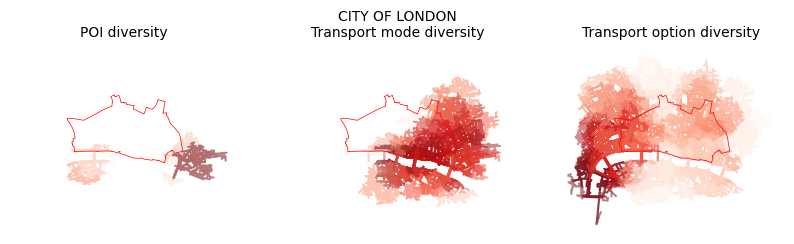

In [11]:
# for each boro in boro geodataframe, plot ALL THREE diversity maps
for boro in boros.iterrows():
    fig, ax = plt.subplots(1,3,sharex=True, sharey=True,figsize=(10,10))
    
    boro_name = boro[1].NAME
    boro_geom = boro[1].geometry
    for i in range(3):
        boros[boros.NAME == boro_name].boundary.plot(ax=ax[i], color='red', linewidth=0.5)

    df_plot = df_ml_div[df_ml_div.diversity_poi > df_ml_div.diversity_poi.quantile(0.90)]
    df_plot[df_plot.intersects(boro_geom)].plot(
        column='diversity_poi',
        ax=ax[0],
        legend=False,
        alpha=0.5,
        cmap='Reds'
    )
    ax[0].axis('off')
    ax[0].set_aspect('equal', adjustable='box')
    ax[0].set_title(f'\nPOI diversity', fontsize=10)

    
    df_plot = df_ml_div[df_ml_div.diversity_transp_mode > df_ml_div.diversity_transp_mode.quantile(0.90)] 
    df_plot[df_plot.intersects(boro_geom)].plot(
        column='diversity_transp_mode',
        ax=ax[1],
        legend=False,
        alpha=0.5,
        cmap='Reds'
    )
    ax[1].axis('off')
    ax[1].set_aspect('equal', adjustable='box')
    ax[1].set_title(f'{boro_name.upper()}\nTransport mode diversity', fontsize=10)

    df_plot = df_ml_div[df_ml_div.diversity_transp_opt > df_ml_div.diversity_transp_opt.quantile(0.90)]
    df_plot[df_plot.intersects(boro_geom)].plot(
        column='diversity_transp_opt',
        ax=ax[2],
        legend=False,
        alpha=0.5,
        cmap='Reds'
    )
    ax[2].axis('off')
    ax[2].set_aspect('equal', adjustable='box')
    ax[2].set_title(f'\nTransport option diversity', fontsize=10)

    # #   add legend
    # sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    # sm._A = []
    # cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', pad=0.05, aspect=50,shrink=0.6)

    plt.savefig(os.path.join('output','div',f'div_{boro_name}.png'))
    plt.show()

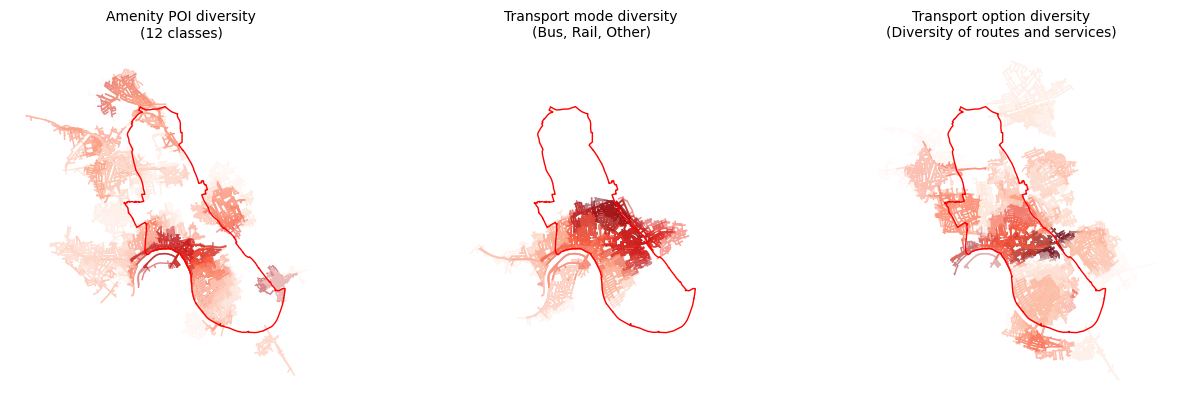

In [12]:
# for each boro in boro geodataframe, plot ALL THREE diversity maps
for boro in boros[boros.NAME=='Hammersmith and Fulham'].iterrows():
    fig, ax = plt.subplots(1,3,sharex=True, sharey=True,figsize=(15,5))
    
    boro_name = boro[1].NAME
    boro_geom = boro[1].geometry
    for i in range(3):
        boros[boros.NAME == boro_name].boundary.plot(ax=ax[i], color='red', linewidth=1)

    df_plot = df_ml_div[df_ml_div.diversity_poi > df_ml_div.diversity_poi.quantile(0.90)]
    df_plot[df_plot.intersects(boro_geom)].plot(
        column='diversity_poi',
        ax=ax[0],
        legend=False,
        alpha=0.5,
        cmap='Reds'
    )
    ax[0].axis('off')
    ax[0].set_aspect('equal', adjustable='box')
    ax[0].set_title(f'Amenity POI diversity\n(12 classes)', fontsize=10)
    
    df_plot = df_ml_div[df_ml_div.diversity_transp_mode > df_ml_div.diversity_transp_mode.quantile(0.90)] 
    df_plot[df_plot.intersects(boro_geom)].plot(
        column='diversity_transp_mode',
        ax=ax[1],
        legend=False,
        alpha=0.5,
        cmap='Reds'
    )
    ax[1].axis('off')
    ax[1].set_aspect('equal', adjustable='box')
    ax[1].set_title(f'Transport mode diversity\n(Bus, Rail, Other)', fontsize=10)

    df_plot = df_ml_div[df_ml_div.diversity_transp_opt > df_ml_div.diversity_transp_opt.quantile(0.90)]
    df_plot[df_plot.intersects(boro_geom)].plot(
        column='diversity_transp_opt',
        ax=ax[2],
        legend=False,
        alpha=0.5,
        cmap='Reds'
    )
    ax[2].axis('off')
    ax[2].set_aspect('equal', adjustable='box')
    ax[2].set_title(f'Transport option diversity\n(Diversity of routes and services)', fontsize=10)
    # plt.suptitle(f'Borough: {boro_name}\nTop 10% value citywide', fontsize=10,y=0.2)
    plt.show()

#### 3.5 Aggregate centrality measures (max_rail, max_bus, combined) for each isochrone

In [44]:
df_ml_cent = df_ml_div.copy()

In [45]:
bus_cent = gpd.read_file(os.path.join('data','cleaned','bus_cent_h3_r10.gpkg'),driver='GPKG',crs='EPSG:27700')
rail_cent = gpd.read_file(os.path.join('data','cleaned','rail_cent_h3_r8.gpkg'),driver='GPKG',crs='EPSG:27700')

In [46]:
bus_cent.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 20060 entries, 0 to 20059
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   h3_10          20060 non-null  object  
 1   STOP_CODE      20060 non-null  object  
 2   STOP_NAME      20060 non-null  object  
 3   degree         20060 non-null  float64 
 4   betweenness_t  20060 non-null  float64 
 5   closeness_t    20060 non-null  float64 
 6   geometry       20060 non-null  geometry
dtypes: float64(3), geometry(1), object(3)
memory usage: 1.1+ MB


In [47]:
rail_cent.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 401 entries, 0 to 400
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   h3_08          401 non-null    object  
 1   station_name   401 non-null    object  
 2   degree         401 non-null    float64 
 3   betweenness_t  401 non-null    float64 
 4   closeness_t    401 non-null    float64 
 5   pagerank_t     401 non-null    float64 
 6   geometry       401 non-null    geometry
dtypes: float64(4), geometry(1), object(2)
memory usage: 22.1+ KB


In [48]:
# iterate through each row of df_ml_cent, find the corresponding intersecting hexagon in bus_cent, and copy the max value of each column
for i, row in df_ml_cent.iterrows():
    intersect = bus_cent[bus_cent.geometry.intersects(row.geometry)] # find intersected polygons
    #for all columns except geometry, rename to bus_
    for col in intersect[['degree','closeness','betweenness']].columns: 
        value = intersect[col].max()
        df_ml_cent.at[i, f'cent_bus_{col}'] = value
    # print progress
    if i%100==0:
        print(f'{i} of {len(df_ml_cent)} done')

0 of 16890 done
100 of 16890 done
200 of 16890 done
300 of 16890 done
400 of 16890 done
500 of 16890 done
600 of 16890 done
700 of 16890 done
800 of 16890 done
900 of 16890 done
1000 of 16890 done
1100 of 16890 done
1200 of 16890 done
1300 of 16890 done
1400 of 16890 done
1500 of 16890 done
1600 of 16890 done
1700 of 16890 done
1800 of 16890 done
1900 of 16890 done
2000 of 16890 done
2100 of 16890 done
2200 of 16890 done
2300 of 16890 done
2400 of 16890 done
2500 of 16890 done
2600 of 16890 done
2700 of 16890 done
2800 of 16890 done
2900 of 16890 done
3000 of 16890 done
3100 of 16890 done
3200 of 16890 done
3300 of 16890 done
3400 of 16890 done
3500 of 16890 done
3600 of 16890 done
3700 of 16890 done
3800 of 16890 done
3900 of 16890 done
4000 of 16890 done
4100 of 16890 done
4200 of 16890 done
4300 of 16890 done
4400 of 16890 done
4500 of 16890 done
4600 of 16890 done
4700 of 16890 done
4800 of 16890 done
4900 of 16890 done
5000 of 16890 done
5100 of 16890 done
5200 of 16890 done
5300 

In [49]:
# iterate through each row of df_ml_cent, find the corresponding intersecting hexagon in bus_cent, and copy the max value of each column
for i, row in df_ml_cent.iterrows():
    intersect = rail_cent[rail_cent.geometry.intersects(row.geometry)] # find intersected polygons
    #for all columns except geometry, rename to bus_
    for col in intersect[['degree','closeness','betweenness']].columns:
        value = intersect[col].max()
        df_ml_cent.at[i, f'cent_rail_{col}'] = value
    # print progress
    if i%100==0:
        print(f'{i} of {len(df_ml_cent)} done')

0 of 16890 done
100 of 16890 done
200 of 16890 done
300 of 16890 done
400 of 16890 done
500 of 16890 done
600 of 16890 done
700 of 16890 done
800 of 16890 done
900 of 16890 done
1000 of 16890 done
1100 of 16890 done
1200 of 16890 done
1300 of 16890 done
1400 of 16890 done
1500 of 16890 done
1600 of 16890 done
1700 of 16890 done
1800 of 16890 done
1900 of 16890 done
2000 of 16890 done
2100 of 16890 done
2200 of 16890 done
2300 of 16890 done
2400 of 16890 done
2500 of 16890 done
2600 of 16890 done
2700 of 16890 done
2800 of 16890 done
2900 of 16890 done
3000 of 16890 done
3100 of 16890 done
3200 of 16890 done
3300 of 16890 done
3400 of 16890 done
3500 of 16890 done
3600 of 16890 done
3700 of 16890 done
3800 of 16890 done
3900 of 16890 done
4000 of 16890 done
4100 of 16890 done
4200 of 16890 done
4300 of 16890 done
4400 of 16890 done
4500 of 16890 done
4600 of 16890 done
4700 of 16890 done
4800 of 16890 done
4900 of 16890 done
5000 of 16890 done
5100 of 16890 done
5200 of 16890 done
5300 

In [50]:
#fill NaN with 0
df_ml_cent.fillna(0,inplace=True) # fill NaN with 0
df_ml_cent.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 16890 entries, 0 to 16889
Data columns (total 48 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   id_code                    16890 non-null  object  
 1   geometry                   16890 non-null  geometry
 2   Total_rail                 16890 non-null  float64 
 3   Early_rail                 16890 non-null  float64 
 4   AM Peak_rail               16890 non-null  float64 
 5   Midday_rail                16890 non-null  float64 
 6   PM Peak_rail               16890 non-null  float64 
 7   Evening_rail               16890 non-null  float64 
 8   Late_rail                  16890 non-null  float64 
 9   Total_bus                  16890 non-null  float64 
 10  Early_bus                  16890 non-null  float64 
 11  AM Peak_bus                16890 non-null  float64 
 12  Midday_bus                 16890 non-null  float64 
 13  PM Peak_bus            

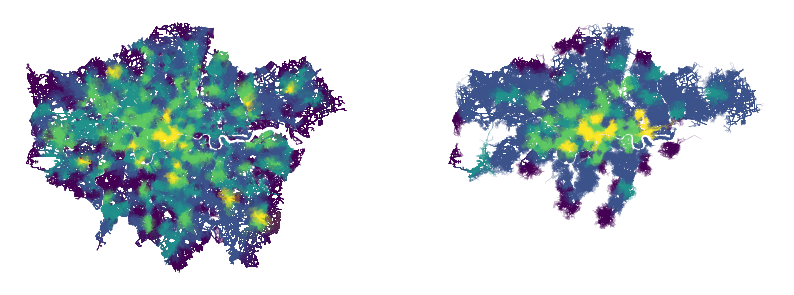

In [54]:
# plot degree
fig, ax = plt.subplots(1,2,figsize=(10,20),sharex=True,sharey=True)
df_ml_cent[df_ml_cent.bus_degree!=0].plot(ax=ax[0], column='bus_degree', alpha=0.5, cmap='viridis',scheme='NaturalBreaks',k=5)
df_ml_cent[df_ml_cent.rail_degree!=0].plot(ax=ax[1], column='rail_degree', alpha=0.5, cmap='viridis',scheme='NaturalBreaks',k=5)
ax[0].axis('off')
ax[1].axis('off')
plt.show()

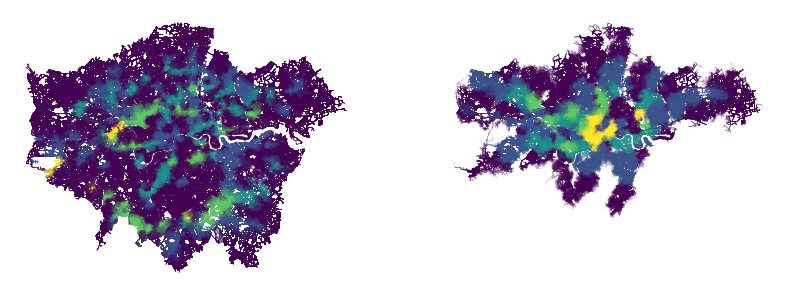

In [57]:
# plot betweenness_t
fig, ax = plt.subplots(1,2,figsize=(10,20),sharex=True,sharey=True)
df_ml_cent[df_ml_cent.bus_betweenness_t!=0].plot(ax=ax[0], column='bus_betweenness_t', alpha=0.5, cmap='viridis',scheme='NaturalBreaks',k=5)
df_ml_cent[df_ml_cent.rail_betweenness_t!=0].plot(ax=ax[1], column='rail_betweenness_t', alpha=0.5, cmap='viridis',scheme='NaturalBreaks',k=5)
ax[0].axis('off')
ax[1].axis('off')
plt.show()

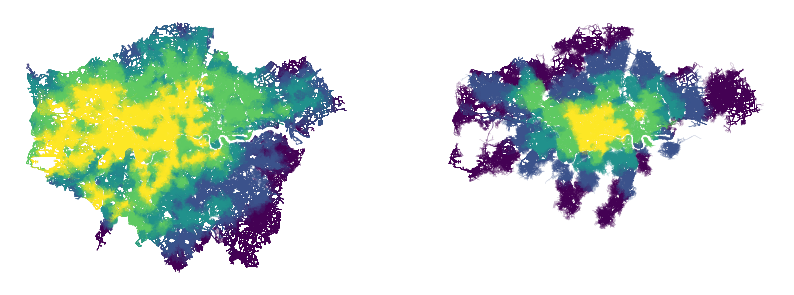

In [58]:
# plot closeness_t
fig, ax = plt.subplots(1,2,figsize=(10,20),sharex=True,sharey=True)
df_ml_cent[df_ml_cent.bus_closeness_t!=0].plot(ax=ax[0], column='bus_closeness_t', alpha=0.5, cmap='viridis',scheme='NaturalBreaks',k=5)
df_ml_cent[df_ml_cent.rail_closeness_t!=0].plot(ax=ax[1], column='rail_closeness_t', alpha=0.5, cmap='viridis',scheme='NaturalBreaks',k=5)
ax[0].axis('off')
ax[1].axis('off')
plt.show()

#### 3.6 Spatial lag as feature

In [14]:
df = pt_isochrone.copy()

In [17]:
# create new columns with log values of target variables
timebands = ['Total', 'Morning', 'Midday', 'Evening', 'Late']
for col in timebands:
    df['log_'+col] = df[col].apply(lambda x: 0 if x==0 else np.log(x))
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 16890 entries, 0 to 16889
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   id_code                    16890 non-null  object  
 1   geometry                   16890 non-null  geometry
 2   population                 16890 non-null  float64 
 3   poi_banking                16890 non-null  float64 
 4   poi_hotels                 16890 non-null  float64 
 5   poi_leisure_active         16890 non-null  float64 
 6   poi_leisure_entertainment  16890 non-null  float64 
 7   poi_leisure_outdoor        16890 non-null  float64 
 8   poi_medical                16890 non-null  float64 
 9   poi_nature                 16890 non-null  float64 
 10  poi_public_facilities      16890 non-null  float64 
 11  poi_religious              16890 non-null  float64 
 12  poi_restaurants            16890 non-null  float64 
 13  poi_shopping           

In [20]:
targets_log = []
for time in timebands:
    targets_log.append('log_'+time)
targets_log

['log_Total', 'log_Morning', 'log_Midday', 'log_Evening', 'log_Late']

In [21]:
# Calculate Moran's I for the target variable, use distance-based spatial weight
from libpysal.weights import DistanceBand
from esda.moran import Moran

# Create a spatial weight matrix using DistanceBand
# weight matrix (750m - calibrated so that every isochrone has at least 1 neighbour)
w = DistanceBand.from_dataframe(df, threshold=750, binary=False)
w.transform = 'r'

# Calculate Moran's I for the log-transformed target variable
for target in targets_log:
    y = df[target]
    moran = Moran(y, w)
    print(target, 'Moran\'s I:', moran.I, 'p-value:', moran.p_sim)


C:\Users\shaun\AppData\Roaming\Python\Python312\site-packages\scipy\sparse\_data.py:133: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)


log_Total Moran's I: 0.7420845350935764 p-value: 0.001
log_Morning Moran's I: 0.7518373113256406 p-value: 0.001
log_Midday Moran's I: 0.7450947781078142 p-value: 0.001
log_Evening Moran's I: 0.7744210246908008 p-value: 0.001
log_Late Moran's I: 0.7962760044779905 p-value: 0.001


In [ ]:
# Local Moran's I, plot LISA
from esda.moran import Moran_Local
from splot.esda import lisa_cluster

# Calculate Local Moran's I for the log-transformed target variable
for target in targets_log:
    y = df[target]
    moran_loc = Moran_Local(y, w)
    lisa_cluster(moran_loc, df, p=0.05, figsize=(12,12))
    plt.suptitle('Local Spatial Autocorrelation Cluster Map\n'+target)
    plt.savefig('output/lisa_'+target+'.jpg')
    plt.tight_layout()
    plt.show()

In [43]:
df_ml_lag = df_ml_cent.copy()
#  get x and y coordinates (as potential features)
df_ml_lag['x_coords'] = df_ml_lag.centroid.x
df_ml_lag['y_coords'] = df_ml_lag.centroid.y

In [49]:
# create spatial lag for each timeband
for col in timebands:
    spatial_lag = ps.weights.lag_spatial(w, df_ml_lag[col])
    df_ml_lag[f'lag_{col}'] = spatial_lag

df_ml_lag.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 16890 entries, 0 to 16889
Data columns (total 39 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   id_code                    16890 non-null  object  
 1   geometry                   16890 non-null  geometry
 2   population                 16890 non-null  float64 
 3   poi_banking                16890 non-null  float64 
 4   poi_hotels                 16890 non-null  float64 
 5   poi_leisure_active         16890 non-null  float64 
 6   poi_leisure_entertainment  16890 non-null  float64 
 7   poi_leisure_outdoor        16890 non-null  float64 
 8   poi_medical                16890 non-null  float64 
 9   poi_nature                 16890 non-null  float64 
 10  poi_public_facilities      16890 non-null  float64 
 11  poi_religious              16890 non-null  float64 
 12  poi_restaurants            16890 non-null  float64 
 13  poi_shopping           

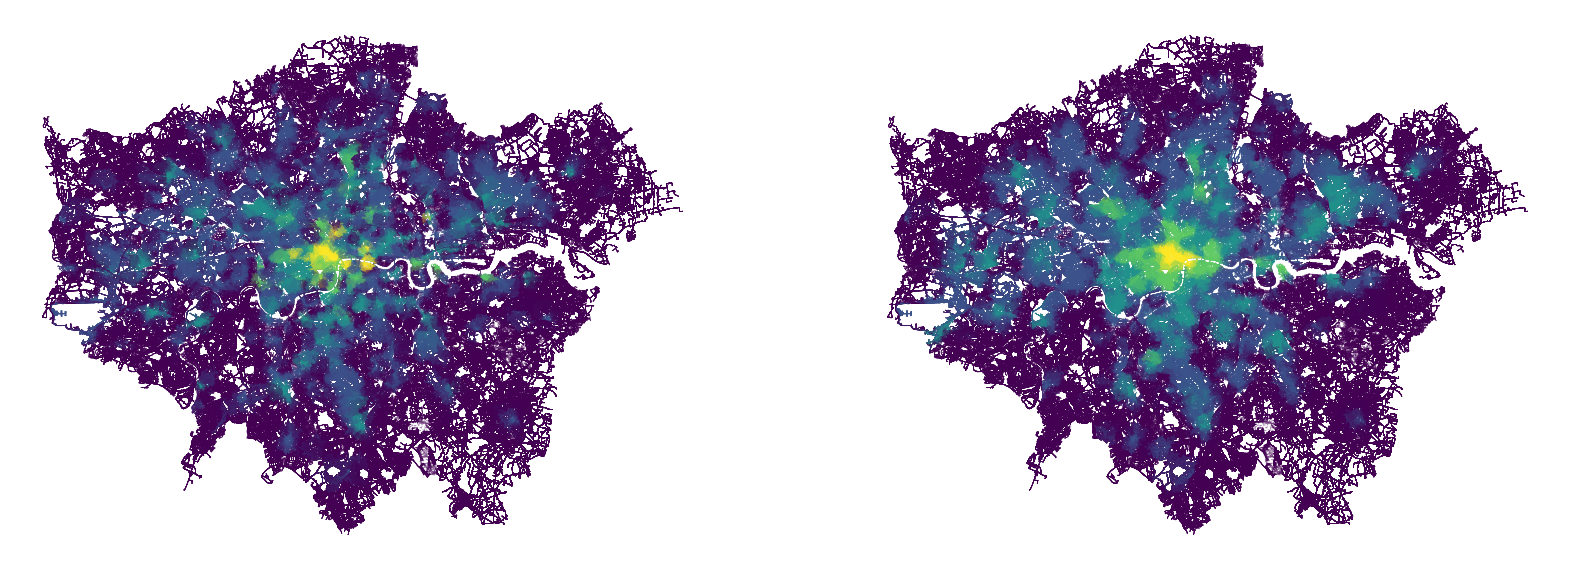

In [51]:
# plot Total and lag_Total side by side
fig, ax = plt.subplots(1,2,figsize=(20,20),sharex=True,sharey=True)
df_ml_lag.plot(ax=ax[0], column='Total', alpha=0.5, cmap='viridis',scheme='NaturalBreaks',k=5)
df_ml_lag.plot(ax=ax[1], column='lag_Total', alpha=0.5, cmap='viridis',scheme='NaturalBreaks',k=5)
ax[0].axis('off')
ax[1].axis('off')
plt.suptitle('Total and lag_Total (750m)')
plt.show()

In [52]:
df_ml_lag.to_csv(os.path.join('data','cleaned','df_ml_new.csv'),index=False)